# 12 - Attention is All You Need
Prepared by Jan Christian Blaise Cruz

DLSU Machine Learning Group

In this session, we'll implement the Transformer Seq2Seq model proposed in Vaswani et al. (2017).

# Preliminaries

Make sure we have a GPU to use.

In [ ]:
!nvidia-smi

Fri Sep  4 12:39:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Download the datasets and the necessary packages. Make sure to reset the runtime after.

In [ ]:
!wget https://s3.us-east-2.amazonaws.com/blaisecruz.com/datasets/translation/multi30k.zip
!unzip multi30k.zip && rm multi30k.zip
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm
!pip install --upgrade torchtext

Import our usual packages.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as datautils

import spacy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

import random
from collections import Counter
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

# Data Processing

Data processing remains the same. Load the Multi30k dataset.

In [ ]:
with open('multi30k/train.en', 'r') as f:
    train_en = [line.strip() for line in f]
with open('multi30k/train.de', 'r') as f:
    train_de = [line.strip() for line in f]
with open('multi30k/val.en', 'r') as f:
    valid_en = [line.strip() for line in f]
with open('multi30k/val.de', 'r') as f:
    valid_de = [line.strip() for line in f]

Load our tokenizers and tokenize.

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return ['<sos>'] + [tok.text.lower() for tok in spacy_de.tokenizer(text)] + ['<eos>']

def tokenize_en(text):
    return ['<sos>'] + [tok.text.lower() for tok in spacy_en.tokenizer(text)] + ['<eos>']

# Tokenize the text
train_en = [tokenize_en(text) for text in tqdm(train_en)]
train_de = [tokenize_de(text) for text in tqdm(train_de)]
valid_en = [tokenize_en(text) for text in tqdm(valid_en)]
valid_de = [tokenize_de(text) for text in tqdm(valid_de)]

100%|██████████| 1014/1014 [00:00<00:00, 16138.12it/s]


Delimit our sequences.

In [ ]:
def process(dataset):
    max_len = max([len(text) for text in dataset])
    temp = []
    for text in dataset:
        if len(text) < max_len:
            text += ['<pad>' for _ in range(max_len - len(text))]
        temp.append(text)
    return temp

# Pad to maximum length of the dataset
train_en_proc, valid_en_proc = process(train_en), process(valid_en)
train_de_proc, valid_de_proc = process(train_de), process(valid_de)

Produce our vocabularies.

In [ ]:
def get_vocab(dataset, min_freq=2):
    # Add all tokens to the list
    special_tokens = ['<unk>', '<pad>', '<sos>', '<eos>']
    vocab = []
    for line in dataset: vocab.extend(line)

    # Remove words that are below the minimum frequency, the enforce set
    counts = Counter(vocab)
    vocab = special_tokens + [word for word in counts.keys() if counts[word] > min_freq]
    vocab_set = set(vocab)

    # Push all special tokens to the front
    idx2word = list(vocab_set)
    for token in special_tokens[::-1]:
        idx2word.insert(0, idx2word.pop(idx2word.index(token)))

    # Produce word2idx then return
    word2idx = {idx2word[i]: i for i in range(len(idx2word))}
    return vocab_set, idx2word, word2idx

# Get vocabulary and references
vocab_set_en, idx2word_en, word2idx_en = get_vocab(train_en_proc, min_freq=2)
vocab_set_de, idx2word_de, word2idx_de = get_vocab(train_de_proc, min_freq=2)

# Convert unknown tokens
train_en_proc = [[token if token in vocab_set_en else '<unk>' for token in line] for line in train_en_proc]
train_de_proc = [[token if token in vocab_set_de else '<unk>' for token in line] for line in train_de_proc]
valid_en_proc = [[token if token in vocab_set_en else '<unk>' for token in line] for line in valid_en_proc]
valid_de_proc = [[token if token in vocab_set_de else '<unk>' for token in line] for line in valid_de_proc]

Convert to their indices.

In [ ]:
def serialize(dataset, word2idx):
    temp = []
    for line in dataset: temp.append([word2idx[token] for token in line])
    return torch.LongTensor(temp)

# Convert to idx
y_train = serialize(train_en_proc, word2idx_en)
X_train = serialize(train_de_proc, word2idx_de)
y_valid = serialize(valid_en_proc, word2idx_en)
X_valid = serialize(valid_de_proc, word2idx_de)

Produce dataloaders.

In [ ]:
bs = 128

train_dataset = datautils.TensorDataset(X_train, y_train)
valid_dataset = datautils.TensorDataset(X_valid, y_valid)
train_sampler = datautils.RandomSampler(train_dataset)
train_loader = datautils.DataLoader(train_dataset, batch_size=bs, sampler=train_sampler)
valid_loader = datautils.DataLoader(valid_dataset, batch_size=bs, shuffle=False)

Transformers produce outputs batch-wise, so we won't be rotating our tensors here.

In [ ]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([128, 46]) torch.Size([128, 43])


# Modeling

First, we implement the Multihead Attention module as described in the slides.

In [ ]:
class MultiheadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout=0.5):
        super(MultiheadAttentionLayer, self).__init__()
        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // n_heads
        self.scale = np.sqrt(self.head_dim)

    def forward(self, query, key, value, mask=None):
        bs = query.shape[0]
        Q = self.fc_q(query).view(bs, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.fc_k(key).view(bs, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.fc_v(value).view(bs, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        if mask is not None: energy = energy.masked_fill(mask==0, -1e10)

        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attention), V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(bs, -1, self.hidden_dim)
        x = self.fc_o(x)
        return x, attention

As directed by the paper, our linear layers are actually composed of **two** linear layers, with a bottleneck in the middle. We'll implement this as a module that we can drop in as a replacement to standard linear layers.

In [ ]:
class PositionFeedForward(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout=0.5):
        super(PositionFeedForward, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.dropout(torch.relu(self.fc1(x)))
        out = self.fc2(out)
        return out

Here is one encoder block. Compute self attention followed by an add-and-norm skip connection, then a feedforward, followed by an add-and-norm skip connection.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout=0.5):
        super(EncoderLayer, self).__init__()
        self.at_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.attention = MultiheadAttentionLayer(hidden_dim, n_heads, dropout=dropout)
        self.positionwise_ff = PositionFeedForward(hidden_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        _out, _ = self.attention(x, x, x, mask)
        out = self.at_layer_norm(x + self.dropout(_out))
        _out = self.positionwise_ff(out)
        out = self.ff_layer_norm(out + self.dropout(_out))
        return out

We'll wrap everything into an Encoder module. This is also where we will add our token and position embeddings.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_sz, hidden_dim, n_layers, n_heads, pf_dim, dropout=0.5, msl=100):
        super(Encoder, self).__init__()
        self.token_embedding = nn.Embedding(vocab_sz, hidden_dim)
        self.posit_embedding = nn.Embedding(msl, hidden_dim)
        layers = [EncoderLayer(hidden_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)]
        self.layers = nn.ModuleList(layers)
        self.dropout = nn.Dropout(dropout)
        self.scale = np.sqrt(hidden_dim)

    def forward(self, x, mask):
        bs, msl = x.shape
        pos = torch.arange(0, msl).unsqueeze(0).repeat(bs, 1).to(next(self.parameters()).device)
        out = self.token_embedding(x) * self.scale + self.posit_embedding(pos)
        out = self.dropout(out)

        for layer in self.layers:
            out = layer(out, mask)
        return out

Our decoder blocks will be similar, except we accept masks for the masked attention (decoder self attention) and the multiheaded context attention (the attention to the input tokens).

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout=0.5):
        super(DecoderLayer, self).__init__()
        self.self_at_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.enco_at_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiheadAttentionLayer(hidden_dim, n_heads, dropout)
        self.enco_attention = MultiheadAttentionLayer(hidden_dim, n_heads, dropout)
        self.positionwise_ff = PositionFeedForward(hidden_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, y, enc_src, src_mask, trg_mask):
        _out, _ = self.self_attention(y, y, y, trg_mask)
        out = self.self_at_layer_norm(y + self.dropout(_out))
        _out, attention = self.enco_attention(out, enc_src, enc_src, src_mask)
        out = self.enco_at_layer_norm(out + self.dropout(_out))
        _out = self.positionwise_ff(out)
        out = self.ff_layer_norm(out + self.dropout(_out))
        return out, attention

We'll wrap that up in a Decoder module.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_sz, hidden_dim, n_layers, n_heads, pf_dim, dropout, msl=100):
        super(Decoder, self).__init__()
        self.token_embedding = nn.Embedding(vocab_sz, hidden_dim)
        self.posit_embedding = nn.Embedding(msl, hidden_dim)
        layers = [DecoderLayer(hidden_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)]
        self.layers = nn.ModuleList(layers)
        self.fc1 = nn.Linear(hidden_dim, vocab_sz)
        self.dropout = nn.Dropout(dropout)
        self.scale = np.sqrt(hidden_dim)

    def forward(self, y, enc_src, src_mask, trg_mask):
        bs, msl = y.shape
        pos = torch.arange(0, msl).unsqueeze(0).repeat(bs, 1).to(next(self.parameters()).device)
        out = self.token_embedding(y) * self.scale + self.posit_embedding(pos)
        out = self.dropout(out)

        for layer in self.layers:
            out, attention = layer(out, enc_src, src_mask, trg_mask)
        out = self.fc1(out)

        return out, attention

And then write our Sequence-to-Sequence wrapper.

Like we said, Transformers produce tokens batch-wise, so we don't need to do token-by-token decoding here.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_ix, trg_pad_ix):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_ix = src_pad_ix
        self.trg_pad_ix = trg_pad_ix

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name: nn.init.xavier_uniform_(param.data)

    def make_src_mask(self, x):
        mask = (x != self.src_pad_ix).unsqueeze(1).unsqueeze(2)
        return mask

    def make_trg_mask(self, y):
        bs, msl = y.shape
        mask = (y != self.trg_pad_ix).unsqueeze(1).unsqueeze(2)
        submask = torch.tril(torch.ones(msl, msl)).bool().to(next(self.parameters()).device)
        mask = mask & submask
        return mask

    def forward(self, x, y):
        src_mask = self.make_src_mask(x)
        trg_mask = self.make_trg_mask(y)

        enc_src = self.encoder(x, src_mask)
        out, attention = self.decoder(y, enc_src, src_mask, trg_mask)
        return out, attention

# Training

Produce a setup as directed by the paper.

In [ ]:
epochs = 10

encoder = Encoder(vocab_sz=len(vocab_set_de), hidden_dim=256, n_layers=3, n_heads=8, pf_dim=512, dropout=0.1)
decoder = Decoder(vocab_sz=len(vocab_set_en), hidden_dim=256, n_layers=3, n_heads=8, pf_dim=512, dropout=0.1)
model = Seq2Seq(encoder, decoder, word2idx_de['<pad>'], word2idx_en['<pad>']).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2idx_en['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader)*epochs)

Count the number of trainable parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print("The model has {:,} trainable parameters".format(count_parameters(model)))

The model has 7,718,348 trainable parameters


For transparency, here is our (giant) model.

In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (token_embedding): Embedding(5376, 256)
    (posit_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (at_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attention): MultiheadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_ff): PositionFeedForward(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1,

And then train. Note that since we don't do token-by-token decoding, we don't need the end of sequence token while training, so we cut it off for the targets. When calculating the loss, we cut off the start of sequence token as we expect the model to produce its own eos token.

In [ ]:
clip = 1.0

for e in range(1, epochs + 1):
    train_loss = 0
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        out, _ = model(x, y[:, :-1])
        loss = criterion(out.contiguous().flatten(0, 1), 
                         y[:, 1:].contiguous().flatten(0))
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    valid_loss = 0
    model.eval()
    for batch in tqdm(valid_loader):
        with torch.no_grad():
            x, y = x.to(device), y.to(device)

            out, _ = model(x, y[:, :-1])
            loss = criterion(out.contiguous().flatten(0, 1), 
                             y[:, 1:].contiguous().flatten(0))

            valid_loss += loss.item()
    valid_loss /= len(valid_loader)

    print("\nEpoch {:3} | Train Loss {:.4f} | Train Ppl {:.4f} | Valid Loss {:.4f} | Valid Ppl {:.4f}".format(e, train_loss, np.exp(train_loss), valid_loss, np.exp(valid_loss)))

  1%|          | 2/227 [00:00<00:18, 12.19it/s]


Epoch   1 | Train Loss 4.0129 | Train Ppl 55.3056 | Valid Loss 3.0601 | Valid Ppl 21.3295


  1%|          | 2/227 [00:00<00:18, 12.14it/s]


Epoch   2 | Train Loss 2.9693 | Train Ppl 19.4773 | Valid Loss 2.4971 | Valid Ppl 12.1471


  1%|          | 2/227 [00:00<00:18, 12.23it/s]


Epoch   3 | Train Loss 2.5747 | Train Ppl 13.1278 | Valid Loss 2.3101 | Valid Ppl 10.0754


  1%|          | 2/227 [00:00<00:18, 12.23it/s]


Epoch   4 | Train Loss 2.3152 | Train Ppl 10.1269 | Valid Loss 1.8826 | Valid Ppl 6.5706


  1%|          | 2/227 [00:00<00:18, 12.09it/s]


Epoch   5 | Train Loss 2.1296 | Train Ppl 8.4116 | Valid Loss 1.8973 | Valid Ppl 6.6677


  1%|          | 2/227 [00:00<00:18, 12.11it/s]


Epoch   6 | Train Loss 1.9914 | Train Ppl 7.3261 | Valid Loss 1.6551 | Valid Ppl 5.2337


  1%|          | 2/227 [00:00<00:18, 12.01it/s]


Epoch   7 | Train Loss 1.8886 | Train Ppl 6.6104 | Valid Loss 1.5772 | Valid Ppl 4.8413


  1%|          | 2/227 [00:00<00:18, 12.28it/s]


Epoch   8 | Train Loss 1.8209 | Train Ppl 6.1777 | Valid Loss 1.4948 | Valid Ppl 4.4583


  1%|          | 2/227 [00:00<00:18, 12.13it/s]


Epoch   9 | Train Loss 1.7798 | Train Ppl 5.9287 | Valid Loss 1.7271 | Valid Ppl 5.6243


100%|██████████| 8/8 [00:00<00:00, 73.55it/s]


Epoch  10 | Train Loss 1.7642 | Train Ppl 5.8367 | Valid Loss 1.6386 | Valid Ppl 5.1481


Save your model after training.

In [ ]:
torch.save(model.state_dict(), 'seq2seq_transformer.pt')

# Prediction

Load the saved weights.

In [ ]:
encoder = Encoder(vocab_sz=len(vocab_set_de), hidden_dim=256, n_layers=3, n_heads=8, pf_dim=512, dropout=0.1)
decoder = Decoder(vocab_sz=len(vocab_set_en), hidden_dim=256, n_layers=3, n_heads=8, pf_dim=512, dropout=0.1)
model = Seq2Seq(encoder, decoder, word2idx_de['<pad>'], word2idx_en['<pad>']).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx_en['<pad>'])

model.load_state_dict(torch.load('seq2seq_transformer.pt'))
model.eval();

Test on the validation set.

In [ ]:
valid_loss = 0
model.eval()
for batch in tqdm(valid_loader):
    with torch.no_grad():
        x, y = x.to(device), y.to(device)

        out, _ = model(x, y[:, :-1])
        loss = criterion(out.contiguous().flatten(0, 1), 
                         y[:, 1:].contiguous().flatten(0))

        valid_loss += loss.item()
valid_loss /= len(valid_loader)

print("\nValid Loss {:.4f} | Valid Ppl {:.4f}".format(valid_loss, np.exp(valid_loss)))

100%|██████████| 8/8 [00:00<00:00, 72.69it/s]


Valid Loss 1.6386 | Valid Ppl 5.1481


Move the model to the CPU.

In [ ]:
model = model.cpu()

We'll write a difference translate function this time.

Every decoding step, we will pass in a list of tokens that starts off as just the start of sequence marker. At the end of the decoding step, we get the most likely token and add this to the list.

In [ ]:
def translate(src_sentence, model, max_words=20, seed=42):
    s = [token if token in vocab_set_de else '<unk>' for token in src_sentence]
    sample = torch.LongTensor([word2idx_de[token] for token in s]).unsqueeze(0)

    torch.manual_seed(seed)

    with torch.no_grad():
        src_mask = model.make_src_mask(sample)
        enc_src = model.encoder(sample, src_mask)

        tokens = [word2idx_en['<sos>']]

        for _ in range(max_words):
            trg_tensor = torch.LongTensor(tokens).unsqueeze(0)
            trg_mask = model.make_trg_mask(trg_tensor)
            out, attention = model.decoder(trg_tensor, enc_src, src_mask, trg_mask)

            pred_ix = out.argmax(2)[:, -1].item()
            tokens.append(pred_ix)    

            if pred_ix == word2idx_en['<eos>']: break

    # Convert predictions from indices to text. Cut the attentions to translation length
    predictions = [idx2word_en[ix] for ix in tokens]
    attention = attention.squeeze(0).numpy()

    return predictions, attention

We also modify our attention display function to show multiple attention heatmaps.

In [ ]:
def display_attention(src_sentence, predictions, attention, n_heads=8, n_rows=4, n_cols=2):
    assert n_rows * n_cols == n_heads
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        cax = ax.matshow(attention[i], cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + [t.lower() for t in src_sentence], rotation=45)
        ax.set_yticklabels(['']+ predictions)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

And test.

Source: <sos> ein mann schläft in einem grünen raum auf einem sofa . <eos>
Target: <sos> a man sleeping in a green room on a couch . <eos>
Prediction: <sos> a man sleeping on a green couch in a room . <eos>


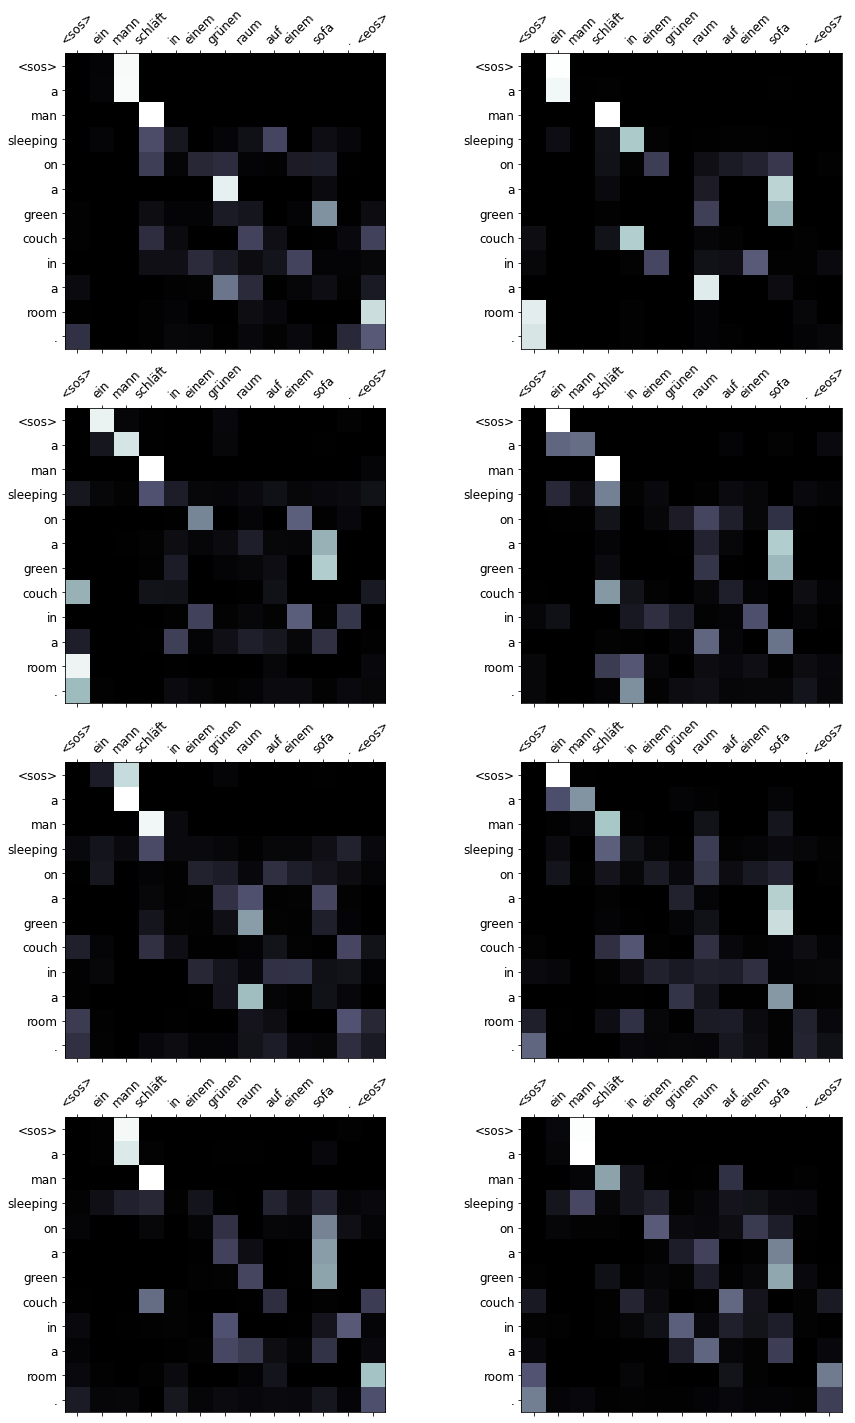

In [ ]:
ix = 1
src_sentence, trg_sentence = valid_de[ix], valid_en[ix]
src_sentence = src_sentence[:src_sentence.index('<eos>') + 1]
trg_sentence = trg_sentence[:trg_sentence.index('<eos>') + 1]

print('Source:', ' '.join(src_sentence))
print('Target:', ' '.join(trg_sentence))

predictions, attention = translate(src_sentence, model)
print('Prediction:', ' '.join(predictions))

display_attention(src_sentence, predictions, attention)

Source: <sos> drei frauen sitzen da und lächeln . <eos>
Target: <sos> three women smiling and sitting down . <eos>
Prediction: <sos> three women sitting and smiling . <eos>


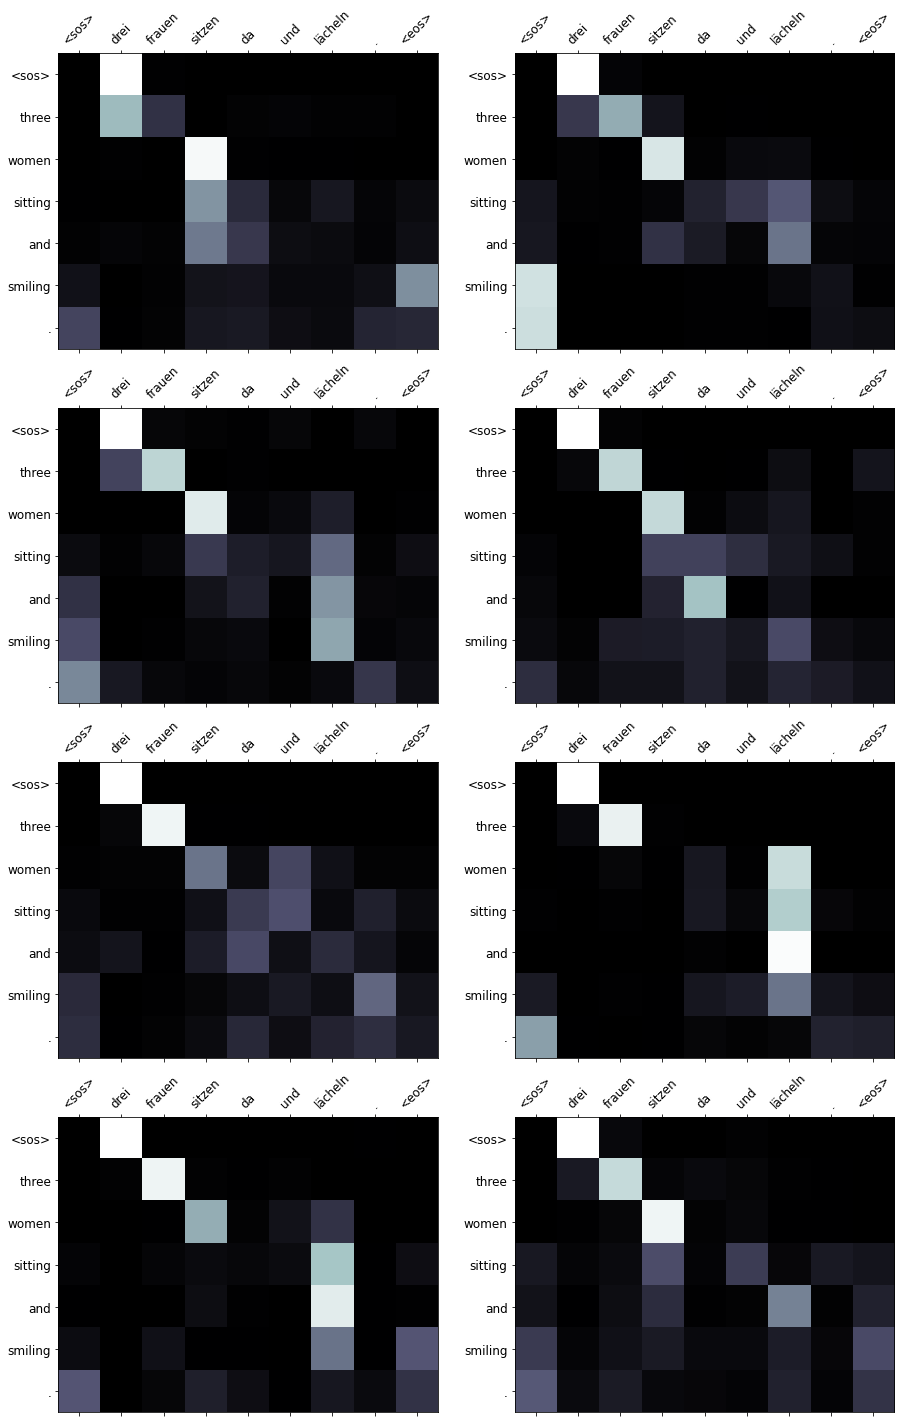

In [ ]:
ix = 60
src_sentence, trg_sentence = valid_de[ix], valid_en[ix]
src_sentence = src_sentence[:src_sentence.index('<eos>') + 1]
trg_sentence = trg_sentence[:trg_sentence.index('<eos>') + 1]

print('Source:', ' '.join(src_sentence))
print('Target:', ' '.join(trg_sentence))

predictions, attention = translate(src_sentence, model)
print('Prediction:', ' '.join(predictions))

display_attention(src_sentence, predictions, attention)

In [ ]:
translations = []
targets = []

for ix in tqdm(range(len(valid_en))):
    src_sentence, trg_sentence = valid_de[ix], valid_en[ix]
    src_sentence = src_sentence[:src_sentence.index('<eos>') + 1]
    trg_sentence = trg_sentence[:trg_sentence.index('<eos>') + 1]

    predictions, _ = translate(src_sentence, model, max_words=50)

    translations.append(predictions[1:-1])
    targets.append(trg_sentence[1:-1])

100%|██████████| 1014/1014 [01:07<00:00, 15.02it/s]


In [ ]:
smoothie = SmoothingFunction().method7
bleu = corpus_bleu(targets, translations, smoothing_function=smoothie)
print("BLEU: {:.2f}".format(bleu * 100))

BLEU: 31.92
